### Clone Dataset & Supporting Files

### Importing Libraries

In [18]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from time import time
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

from sklearn.metrics import confusion_matrix

PyTorch can work on CPU or GPU.

In [2]:
if torch.cuda.is_available():
    deviceStr = "cuda"
else:
    deviceStr = "cpu"
device = torch.device(deviceStr)
print("Device selected:",deviceStr)

Device selected: cpu


### Define Datasets and Dataloaders

Transformation function to be applied on images:
1. Horizontally Flip the image with a probability of 25%
2. Randomly Rotate the image at an angle between -30 to 30 degress.
3. Resize each images to a smallest size of 480 pixels maintaining aspect ratio
4. Crop a square of size 256x256 from the center of image
5. Convert Image to a Pytorch Tensor

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=30),
    transforms.Resize(225),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
])

Creating dataset of transformed images.

In [4]:
dataset_path = 'Dataset'
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

Split the dataset into train, validate and test. 

Ratios: %65, %15, %20

In [5]:
if os.path.isfile("trainDataset.pkl") is True:
    train_dataset = pickle.load(open("trainDataset.pkl","rb"))
    validate_dataset = pickle.load(open("validateDataset.pkl","rb"))
    test_dataset = pickle.load(open("testDataset.pkl","rb"))
    print("Dataset loaded: ",
        len(train_dataset),"train images,", 
        len(validate_dataset),"validate images and",
        len(test_dataset),"test images.")
else:
    dataset_path = 'Dataset'
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
    dataset_len = len(dataset)
    print("There are",dataset_len,"images in dataset.")
    lengths = []
    lengths.append(int(dataset_len*0.65))
    lengths.append(int(dataset_len*0.15))
    lengths.append(int(dataset_len*0.2))
    while (lengths[0] + lengths[1] + lengths[2] != len(dataset)):
        lengths[0] += 1 
    train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)
    print("Dataset splitted into",
        len(train_dataset),"train images,", 
        len(validate_dataset),"validate images and",
        len(test_dataset),"test images.")
    pickle.dump(train_dataset, open("trainDataset.pkl", "wb"))
    pickle.dump(validate_dataset, open("validateDataset.pkl", "wb"))
    pickle.dump(test_dataset, open("testDataset.pkl", "wb"))

Dataset loaded:  2915 train images, 672 validate images and 896 test images.


### Creating data loaders.
We have 4 different batch sizes. Thus there are 12 data loaders.

In [6]:
batchSizeArray = [16, 32, 175, 300]
dataLoaders = []
for i,batchSize in enumerate(batchSizeArray,0):
    dataLoaders.append([])
    dataLoaders[i].append(DataLoader(
        dataset=train_dataset,
        batch_size=batchSize,
        num_workers=4
    ))
    dataLoaders[i].append(DataLoader(
        dataset=validate_dataset,
        batch_size=batchSize,
        num_workers=4
    ))
    dataLoaders[i].append(DataLoader(
        dataset=test_dataset,
        batch_size=batchSize,
        num_workers=4
    ))

### Defile Model Architecture

### PyTorch CNN functions

parameters of Conv2d:
1. in_channel: depth of input image matrix
2. out_channel: number of filters will be applied (output depth)
3. kernel_size: filter size (width and heigth of filter)
4. stride
5. padding

parameters of MaxPool2d:
1. kernel size
2. stride
3. padding (i didn't used)

Flatten function: 

For input of FC layer, we flatten our image matrix with this function.

Dropout function:

In FC layer, we use random dropouts with "dropout_value" probability to prevent overfitting.

Linear function

We use this function to "Fully Connect" nodes.

Batch Normalization

Batch normalization increases training performance.

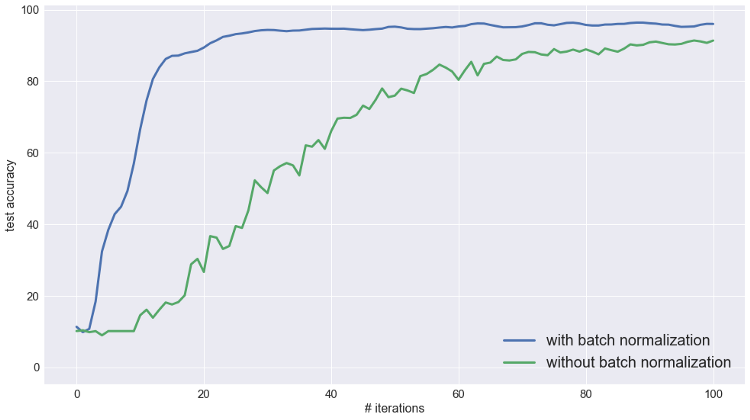


In [7]:
class Model1(nn.Module):
    def __init__(self,dropout_value):
        super(Model1, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, 
                      kernel_size=7, stride=3, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, stride=1, padding=0), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=96, 
                      kernel_size=3, stride=2, padding=0),            
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.MaxPool2d(kernel_size=3,stride=2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2400, 345),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(345, 16)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = Model1().to(device)
summary(model, (3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]           2,368
       BatchNorm2d-2           [-1, 16, 60, 60]              32
              ReLU-3           [-1, 16, 60, 60]               0
           Dropout-4           [-1, 16, 60, 60]               0
            Conv2d-5           [-1, 32, 28, 28]          25,120
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 26, 26]          51,264
      BatchNorm2d-10           [-1, 64, 26, 26]             128
             ReLU-11           [-1, 64, 26, 26]               0
          Dropout-12           [-1, 64, 26, 26]               0
           Conv2d-13           [-1, 64, 24, 24]          36,928
      BatchNorm2d-14           [-1, 64,

As you can see above, Model1 has 5 convolution and 2 FC layer. Also you can see in channels, out channels, stride, padding, kernel size, normalization and activation functions above. There are nearly 1M parameters in this network.

In [8]:
class Model2(nn.Module):
    dropout_value = 0
    def __init__(self,dropout_value):
        super(Model2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=3, padding=2),
            nn.BatchNorm2d(8),
        ).to(device)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16),
        ).to(device)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(8),
        ).to(device)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
        ).to(device)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(8),
        ).to(device)
        self.relu = nn.Sequential(
            nn.ReLU(),
        )
        self.maxPool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1568, 250),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(250, 16)
        ).to(device)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        
        residual = x.clone()     # Beginning of residual connection 1
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        
        x += residual            # End of residual connection 1
        
        x = self.relu(x)
        x = self.maxPool(x)
        
        residual2 = x.clone()    # Beginning of residual connection 2
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        
        x += residual2           # End of residual connection 2
        
        x = self.relu(x)
        x = self.maxPool(x)
        x = self.classifier(x)
        return x

resNetModel = Model2().to(device)
summary(resNetModel, (3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 60, 60]           1,184
       BatchNorm2d-2            [-1, 8, 60, 60]              16
              ReLU-3            [-1, 8, 60, 60]               0
           Dropout-4            [-1, 8, 60, 60]               0
            Conv2d-5           [-1, 16, 60, 60]           1,168
       BatchNorm2d-6           [-1, 16, 60, 60]              32
              ReLU-7           [-1, 16, 60, 60]               0
           Dropout-8           [-1, 16, 60, 60]               0
            Conv2d-9            [-1, 8, 60, 60]           1,160
      BatchNorm2d-10            [-1, 8, 60, 60]              16
             ReLU-11            [-1, 8, 60, 60]               0
          Dropout-12            [-1, 8, 60, 60]               0
        MaxPool2d-13            [-1, 8, 29, 29]               0
           Conv2d-14           [-1, 64,

In this network, there are 2 residual connections. 

First connection is between 2nd convolutional layer's beginning and 3rd convolutional layer's end. 

Second connection is between 4th convolutional layer's beginning and 5th convolutional layer's end.

You can see that, "residual" variable in "forward" function of "Model2" class is used for residual connection.

### Training Procedure

In [47]:
def Train(train_dataloader,model,criterion,optimizer):
    total_loss = 0
    start_time = time()  
    accuracy = []
    
    for i, data in enumerate(train_dataloader, 0):
        inputs, label = data
        output = model(inputs)
        
        loss = criterion(output, label) 
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        argmax = output.argmax(dim=1) 
        accuracy.append((label==argmax).sum().item() / label.shape[0])
    
    return total_loss / len(train_dataloader), sum(accuracy)/len(accuracy)

### Testing Procedure

In [48]:
def Validate(validate_dataloader,model,criterion):
    total_loss = 0
    start_time = time()
    accuracy = []
    
    with torch.no_grad(): 
        for i, data in enumerate(validate_dataloader):
            inputs, label = data
            output = model(inputs)

            loss = criterion(output, label)
            total_loss += loss.item()
            
            argmax = output.argmax(dim=1) 
            accuracy.append((label==argmax).sum().item() / label.shape[0])

    return total_loss/len(validate_dataloader), sum(accuracy)/len(accuracy)

### Training, Validating, Plotting procedure

In [45]:
def trainEvaluatePlot(epochNum,train_dataloader,validate_dataloader,modelNum,lr=0.001,batchSize=300,resNet18 =""):
    print("Model:",modelNum,"Batch Size:",batchSize, "Learning Rate:",lr)
    if (modelNum == 0):
        model = Model1(0.35).to(device)
    if (modelNum == 1):
        model = Model2(0.35).to(device)
    if (modelNum == 2):
        model = resNet18
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    validate_loss = []
    train_accuracy = []
    validate_accuracy = []

    for epoch in range(epochNum):
        train_loss_epoch, train_accuracy_epoch = Train(train_dataloader,model,criterion,optimizer)
        validate_loss_epoch, validate_accuracy_epoch = Validate(validate_dataloader,model,criterion)
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_accuracy_epoch)
        validate_loss.append(validate_loss_epoch)
        validate_accuracy.append(validate_accuracy_epoch)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
    plt.plot(range(1, len(validate_loss)+1), validate_loss, 'b', label='Validating Loss')

    plt.title('Training and Validating loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'g', label='Training Accuracy')
    plt.plot(range(1, len(validate_accuracy)+1), validate_accuracy, 'b', label='Validate Accuracy')

    plt.title('Training and Validating Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

### Model, Optimizer & Loss Function

We have 3 models.

Model 1 is basic CNN. 

Model 2 is basic residual CNN.

Model 3 is pretrained ResNet18.

In first part, we will train our models (1-2) with 4 different batch sizes and 4 different learning rates

I used Adam's algoritm for our optimizer. For loss function, i used Cross Entropy Loss algorithm.

We may see that in some of these output graphs, accuracy suddenly drops. We know that Adam's algorithm decreases learning rate of repeating features. As i said, this algorithm temporarily resets learning rate. This reset causes the accuracy drop.

Model: 0 Batch Size: 16 Learning Rate: 0.01


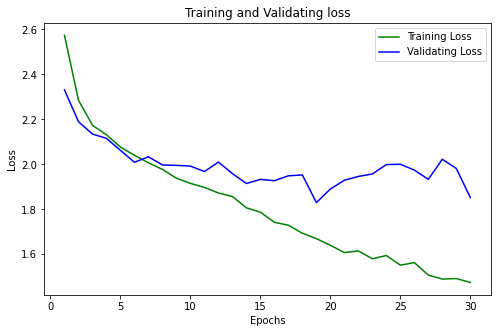

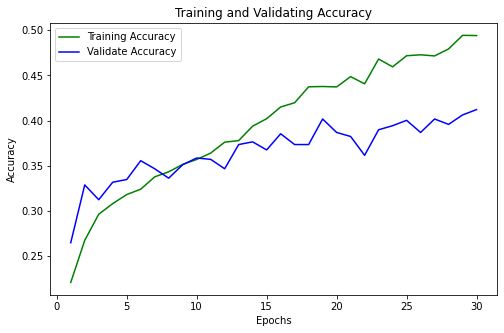

Model: 0 Batch Size: 16 Learning Rate: 0.001


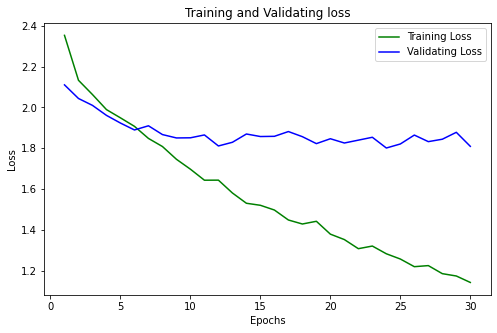

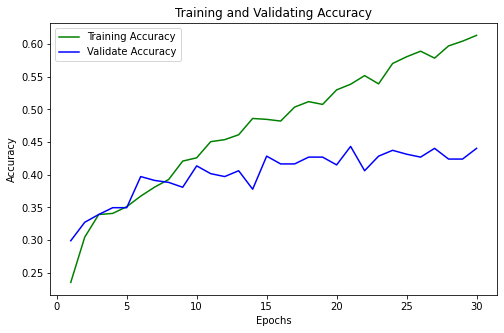

Model: 0 Batch Size: 16 Learning Rate: 0.0005


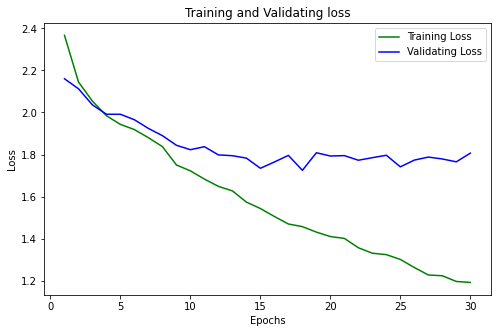

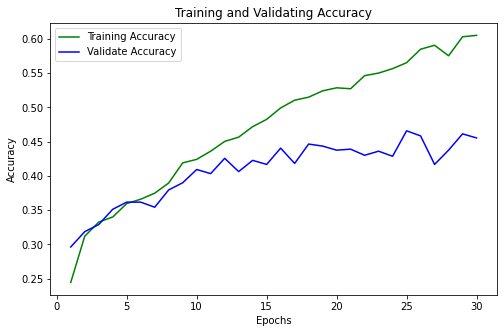

Model: 0 Batch Size: 16 Learning Rate: 0.0001


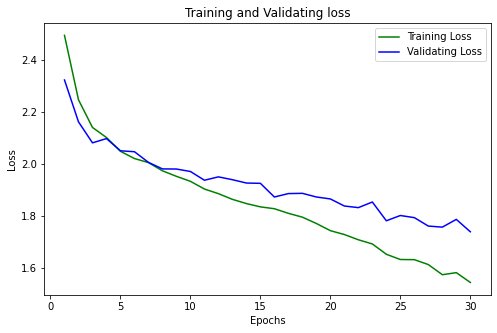

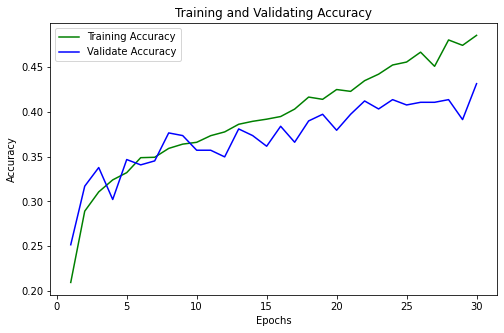

Model: 0 Batch Size: 32 Learning Rate: 0.01


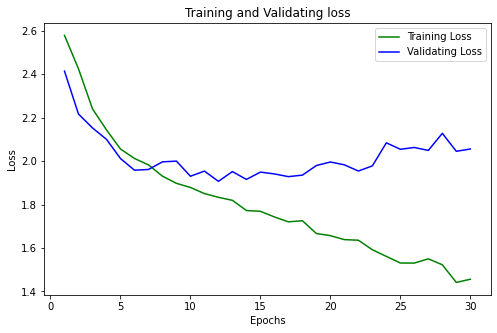

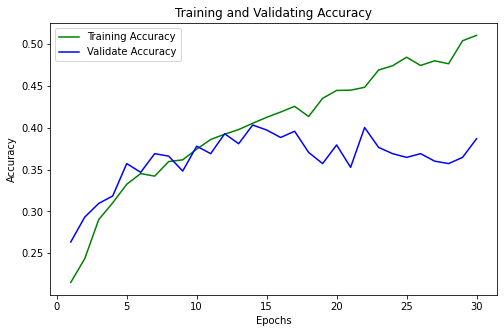

Model: 0 Batch Size: 32 Learning Rate: 0.001


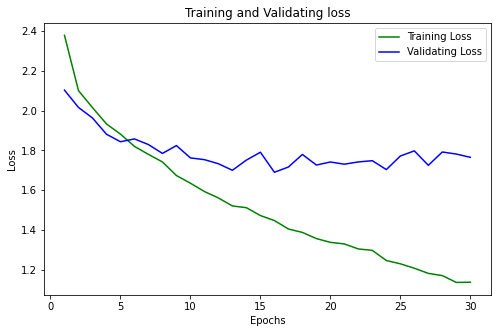

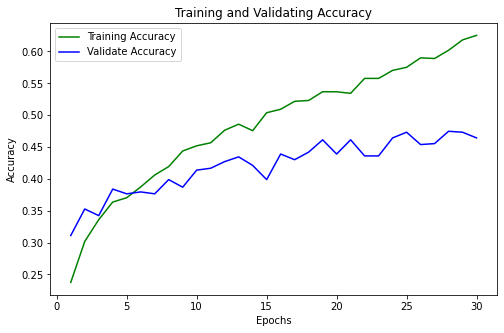

Model: 0 Batch Size: 32 Learning Rate: 0.0005


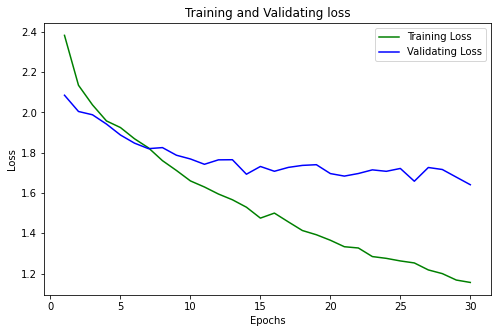

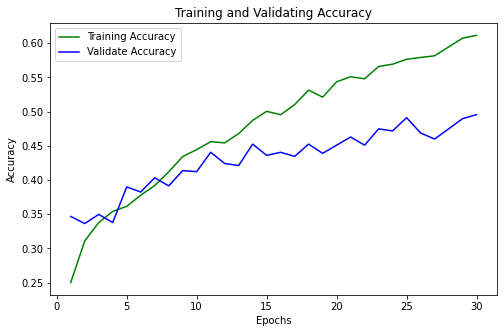

Model: 0 Batch Size: 32 Learning Rate: 0.0001


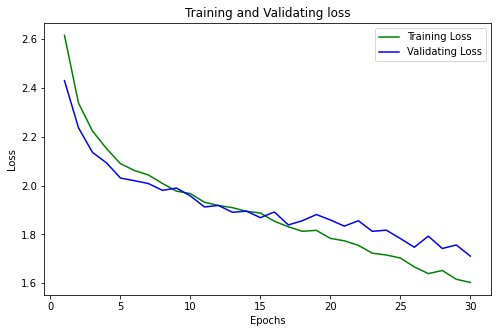

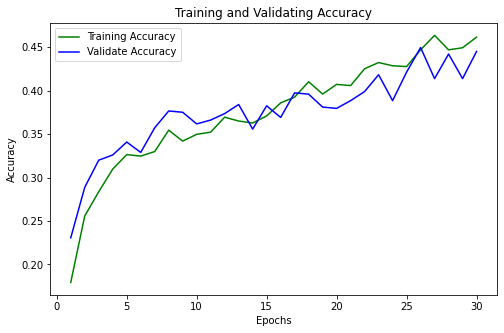

Model: 0 Batch Size: 175 Learning Rate: 0.01


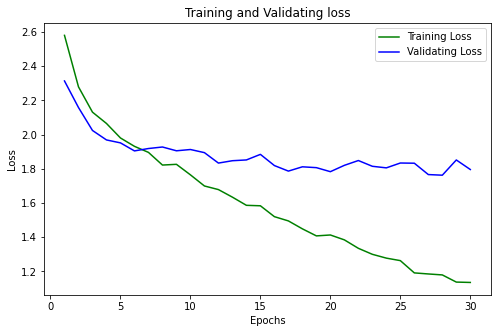

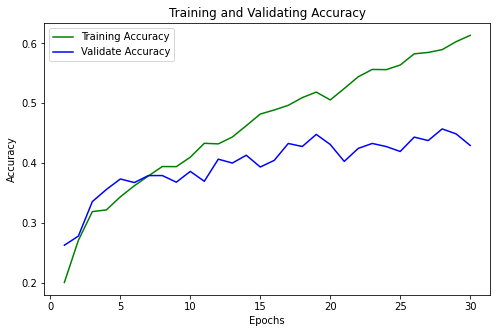

Model: 0 Batch Size: 175 Learning Rate: 0.001


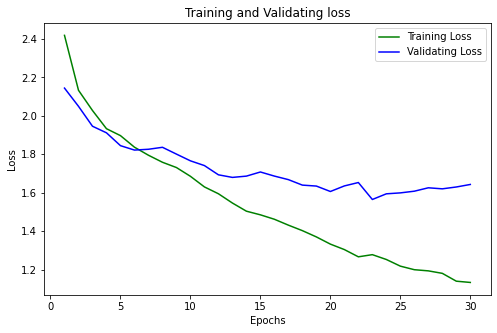

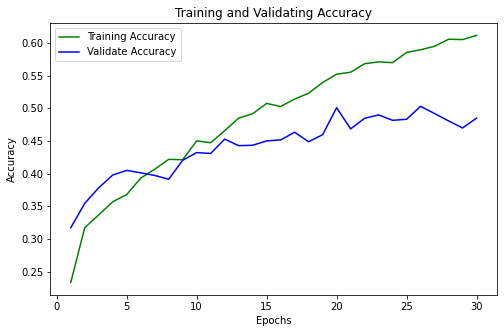

Model: 0 Batch Size: 175 Learning Rate: 0.0005


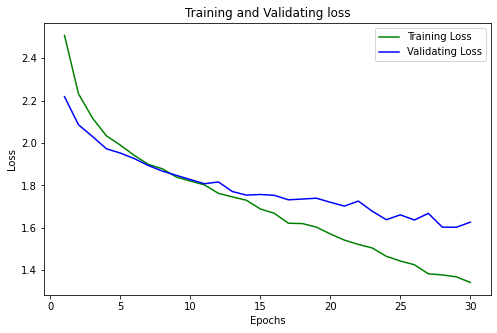

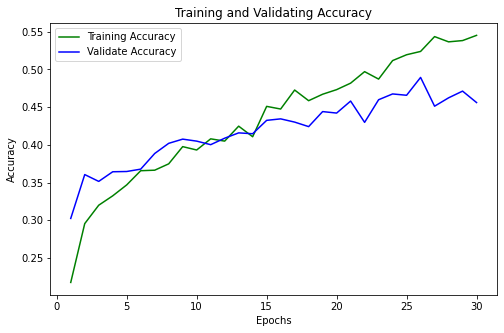

Model: 0 Batch Size: 175 Learning Rate: 0.0001


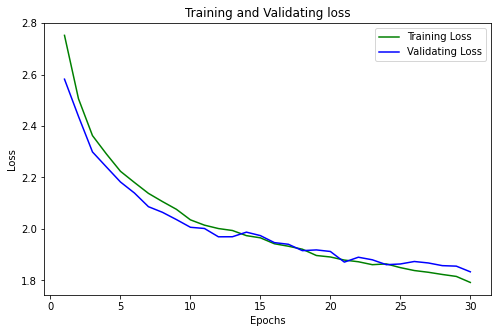

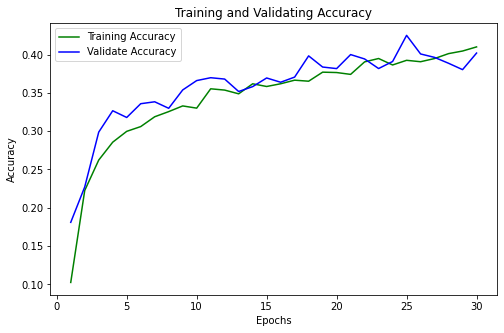

Model: 0 Batch Size: 300 Learning Rate: 0.01


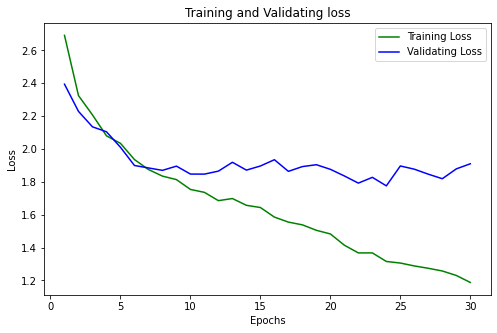

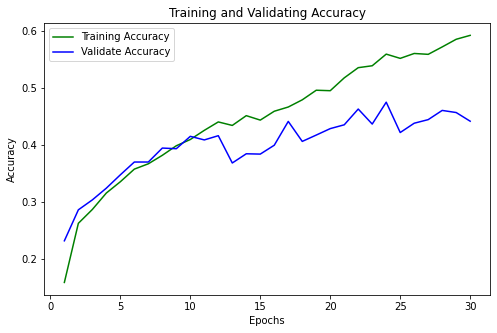

Model: 0 Batch Size: 300 Learning Rate: 0.001


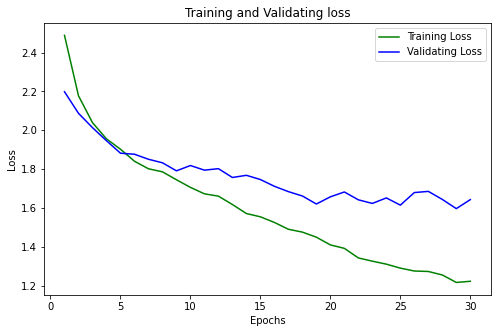

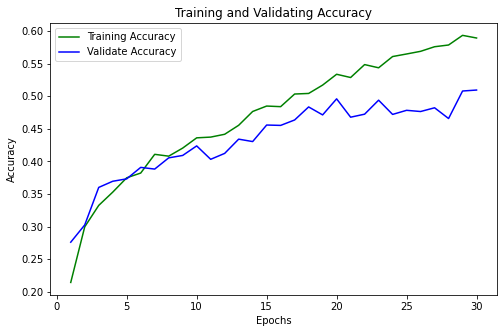

Model: 0 Batch Size: 300 Learning Rate: 0.0005


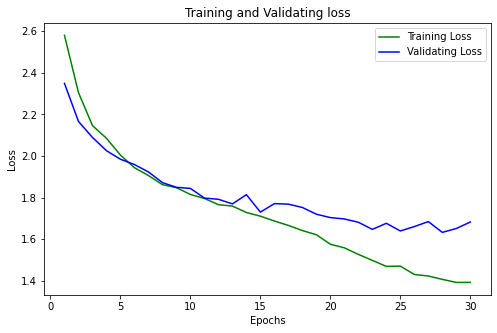

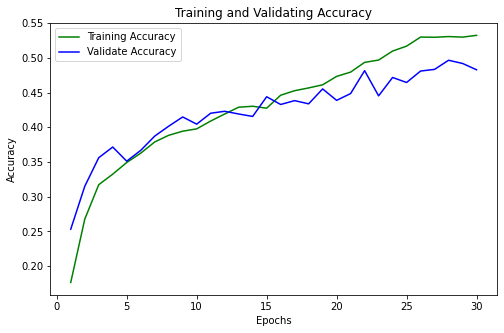

Model: 0 Batch Size: 300 Learning Rate: 0.0001


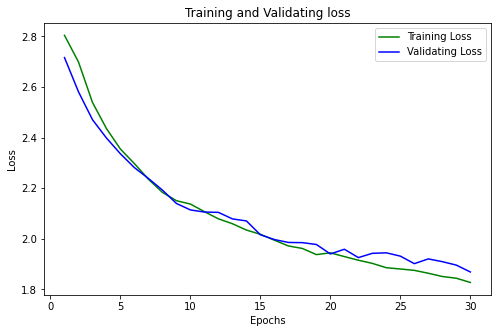

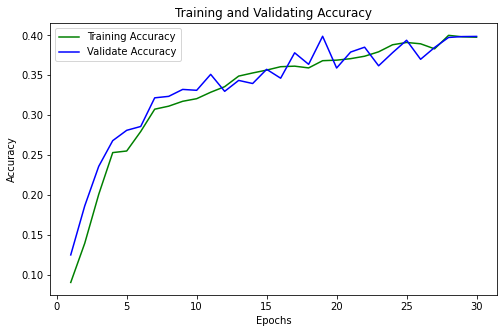

Model: 1 Batch Size: 16 Learning Rate: 0.01


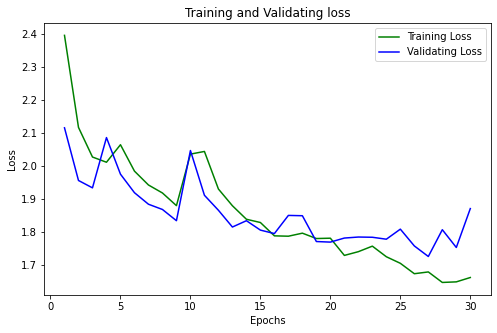

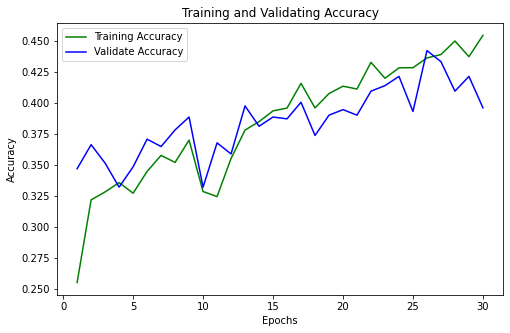

Model: 1 Batch Size: 16 Learning Rate: 0.001


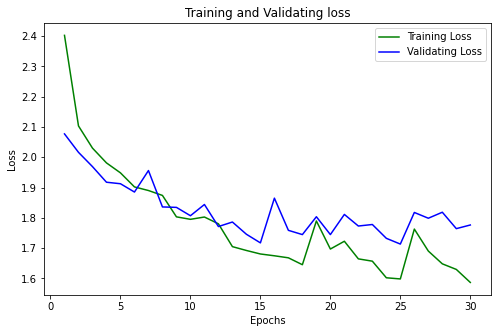

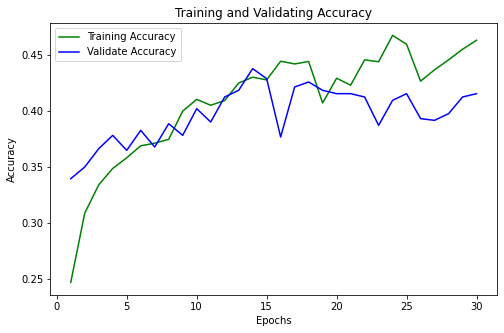

Model: 1 Batch Size: 16 Learning Rate: 0.0005


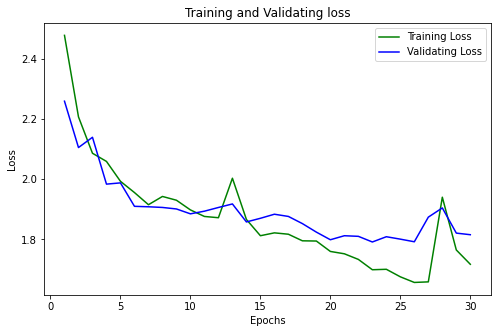

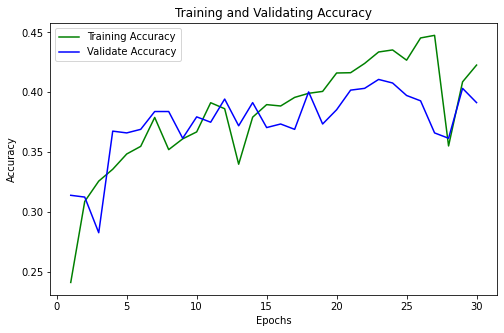

Model: 1 Batch Size: 16 Learning Rate: 0.0001


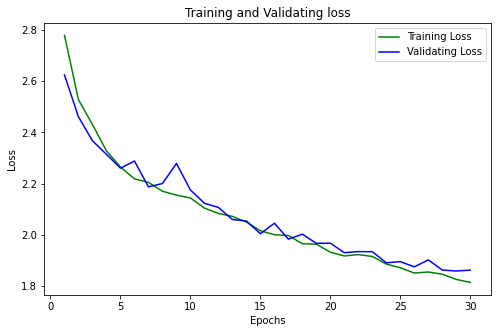

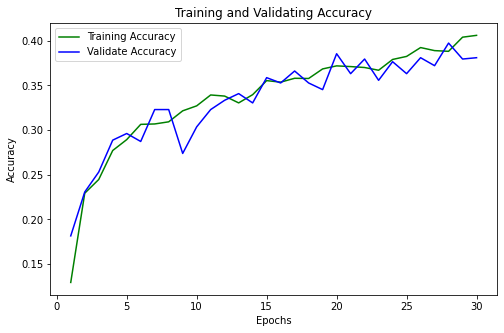

Model: 1 Batch Size: 32 Learning Rate: 0.01


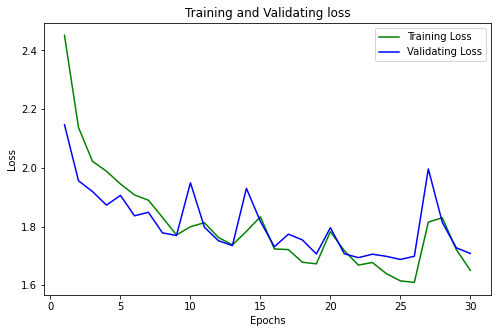

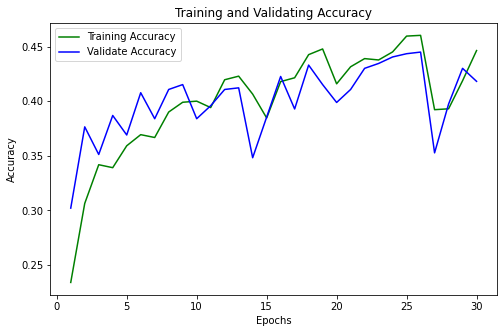

Model: 1 Batch Size: 32 Learning Rate: 0.001


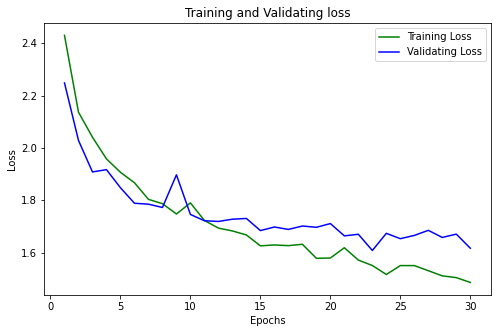

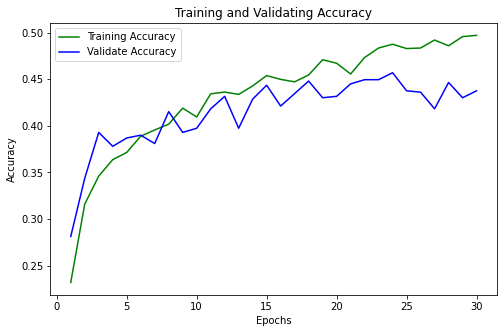

Model: 1 Batch Size: 32 Learning Rate: 0.0005


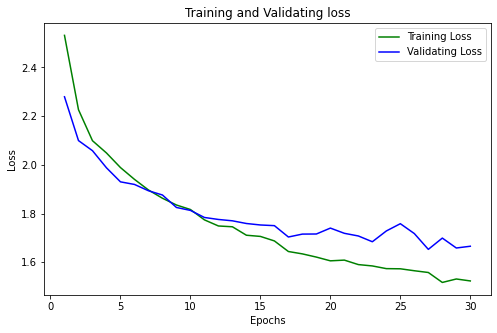

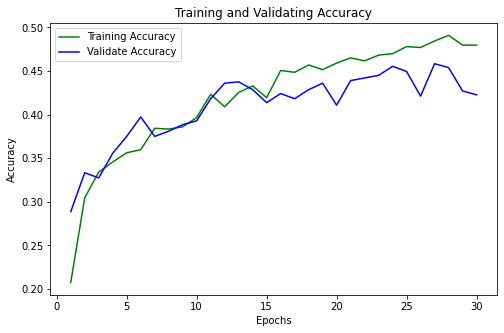

Model: 1 Batch Size: 32 Learning Rate: 0.0001


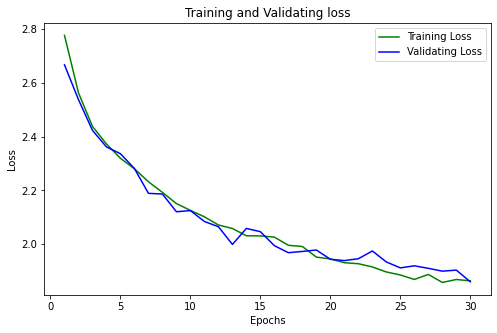

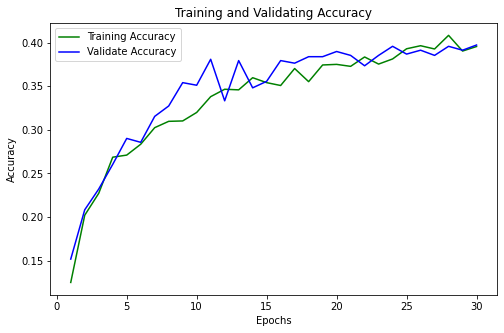

Model: 1 Batch Size: 175 Learning Rate: 0.01


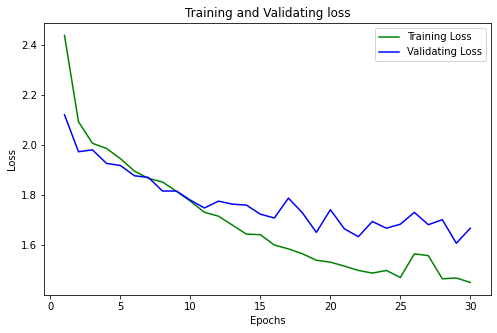

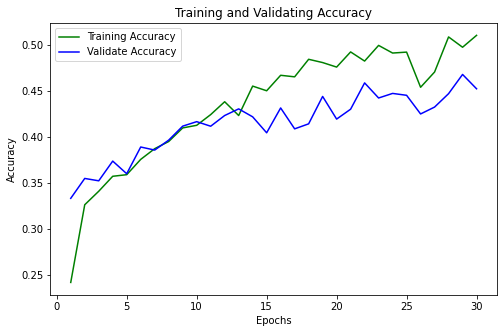

Model: 1 Batch Size: 175 Learning Rate: 0.001


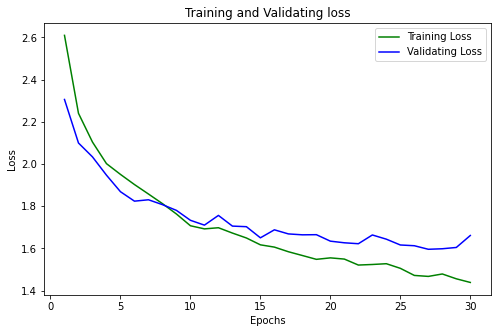

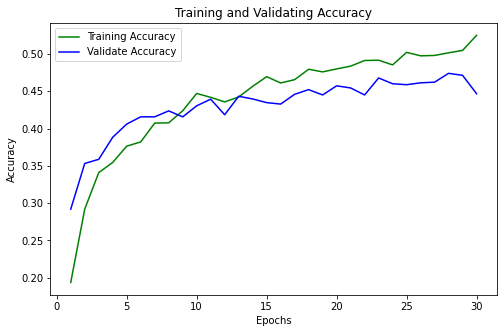

Model: 1 Batch Size: 175 Learning Rate: 0.0005


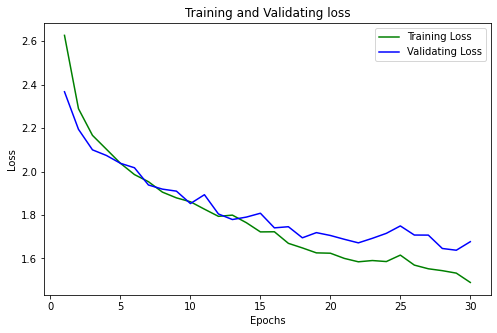

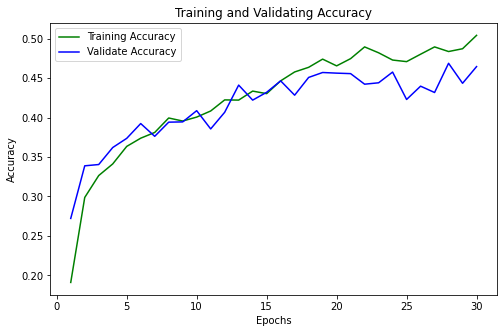

Model: 1 Batch Size: 175 Learning Rate: 0.0001


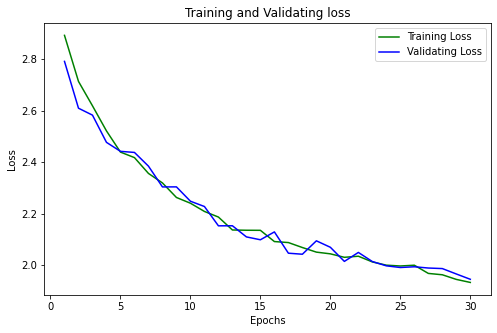

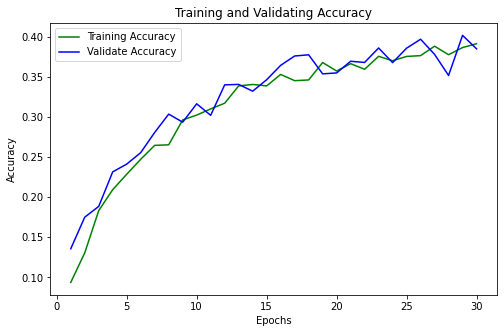

Model: 1 Batch Size: 300 Learning Rate: 0.01


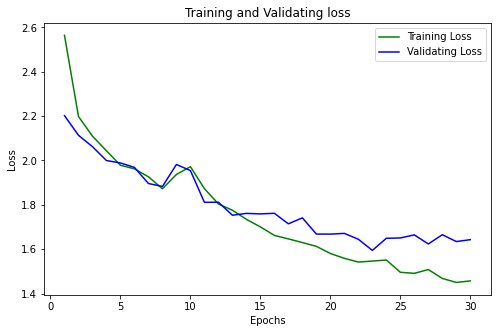

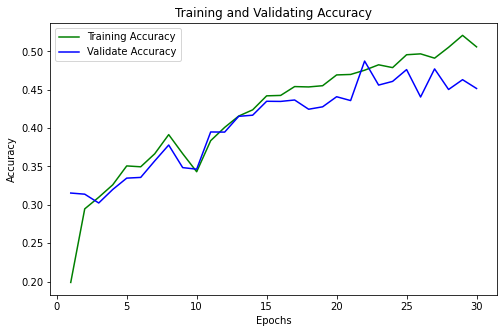

Model: 1 Batch Size: 300 Learning Rate: 0.001


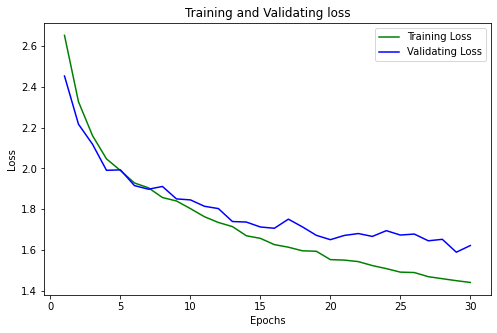

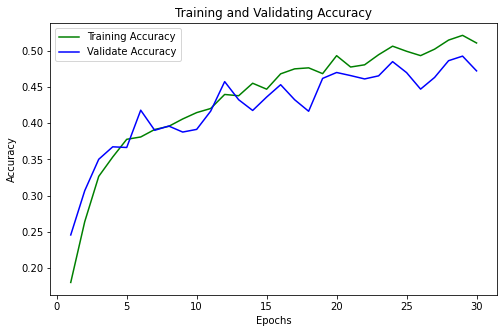

Model: 1 Batch Size: 300 Learning Rate: 0.0005


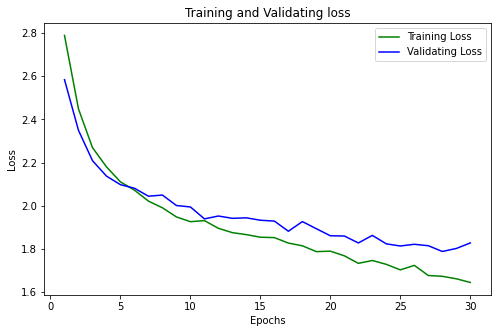

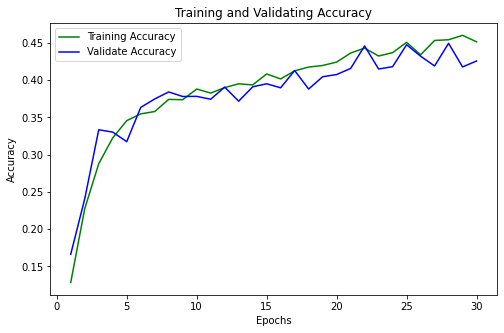

Model: 1 Batch Size: 300 Learning Rate: 0.0001


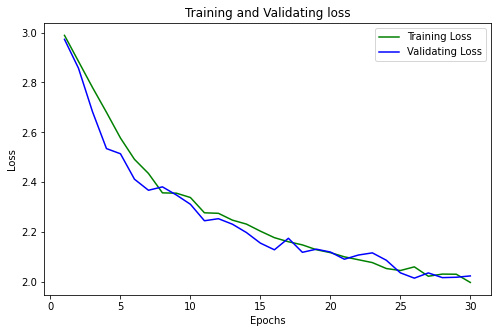

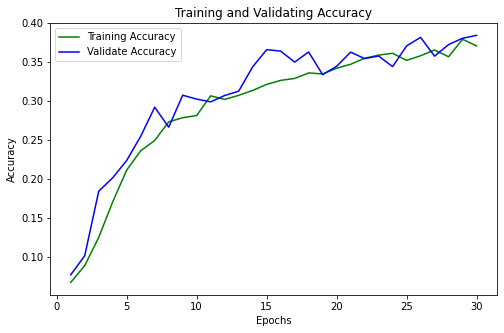

TypeError: cannot pickle 'module' object

In [12]:
myModels = []
number = 0
learningRates = [0.01, 0.001, 0.0005, 0.0001]
for modelNum in range(2):
    for i,batchSize in enumerate(batchSizeArray,0):
        train_dataloader = dataLoaders[i][0]
        validate_dataloader = dataLoaders[i][1]
        for lr in learningRates:
            myModels.append(trainEvaluatePlot(30,batchSize,train_dataloader,validate_dataloader,lr,modelNum))

### Best models

Best model of "Model 1"(basic CNN) is with batch size: 300, learning rate: 0.001

This model has %58 training accuracy and %51 validating accuracy.

Best model of "Model 2"(Residual CNN) is with batch size:300  learning rate: 0.001

This model has %51 training accuracy and %47 validating accuracy.

Residual Convolutional Neural Networks works better on lower learning rates and deeper networks. But my model was made by 5 convolutions and 2 fc layers. So that residual cnn performance was low i think.

Also i made a mistake that, i integrated dropout before these 32 model, and i don't have time to retrain all of these models. Thus i will tell how and why i added dropout.

Dropouts are useful when our model is overfitting. Overfitting is not a good thing. Overfitting increases our training accuracy (fake accuracy) but reduces validation-test accuracy. My model was like it too.

I found a site that shows how we added dropouts and where we add. This site shows us that we need to add dropouts to only fully connected layers and we should add batch normalization to convolutional layers. My model was overfitting, so i used different dropouts like 0.2, 0.3, 0.35, 0.45 and i get different results. The value of 0.35 was best for my model, so i used it.

Link: https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html

### Test accuracies of these models.

In [33]:
def Test(test_dataloader,model,criterion=nn.CrossEntropyLoss()):
    total_loss = 0
    start_time = time()
    accuracy = []
    predictions = torch.tensor([])
    trueLabels = torch.tensor([])
    
    with torch.no_grad(): 
        for i, data in enumerate(test_dataloader):
            inputs, label = data
            output = model(inputs)
            predictions = torch.cat((predictions,output),dim=0)
            trueLabels = torch.cat((trueLabels,label),dim=0)

            loss = criterion(output, label)
            total_loss += loss.item()
            
            argmax = output.argmax(dim=1) 
            accuracy.append((label==argmax).sum().item() / label.shape[0])
    
    print('Test Loss: {:.4f}, Accuracy: {:.2f}'.format(
        total_loss/len(test_dataloader), sum(accuracy)/len(accuracy)
    ))

    return predictions, trueLabels

In [14]:
def drawConfusionMatrix(testLabels,predictions,categories):
    confMatrix = confusion_matrix(testLabels,predictions)
    np.set_printoptions(precision=2)
    confMatrixNormalized = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(confMatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, categories, rotation=45)
    plt.yticks(tick_marks, categories)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Selected ones are 14th and 30th model.

Test Loss: 1.6286, Accuracy: 0.48


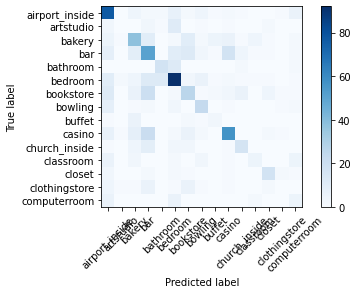

Test Loss: 1.7414, Accuracy: 0.45


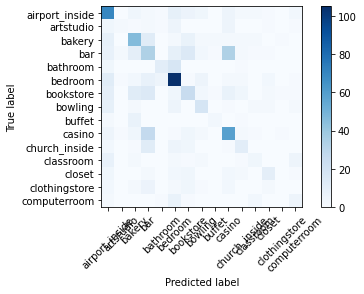

In [43]:
model1 = myModels[13]
model2 = myModels[29]

test_dataloader = dataLoaders[3][2]
predictions, trueLabels = Test(test_dataloader,model1)
predictions = predictions.argmax(dim=1)
drawConfusionMatrix(trueLabels,predictions,test_dataset.dataset.classes)

predictions, trueLabels = Test(test_dataloader,model2)
predictions = predictions.argmax(dim=1)
drawConfusionMatrix(trueLabels,predictions,test_dataset.dataset.classes)

# Transfer learning with ResNet18

We use fine tuning for increase accuracy. While we fine-tuning, we freeze early layers of our pretrained model. Fine-tuning can be only used if pretrained dataset is similar to current dataset. For example, if we already trained "car" images, we can fine tune to train "truck" images. While we doing these train, common features of truck and car are on early layers and details of images on latest layers. Thus we freeze early layers (common ones) and retrain last layers (detailed ones). 

We have different approaches like freezing only FC layer or Last Layer + FC layer. 

### Freezing FC layer

Model: 2 Batch Size: 300 Learning Rate: 0.001


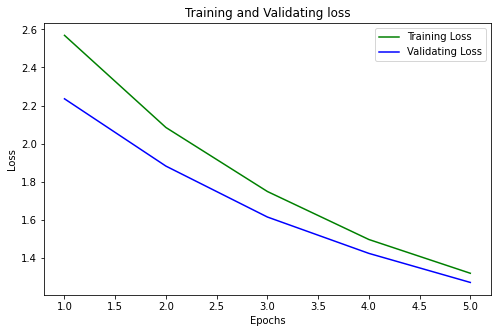

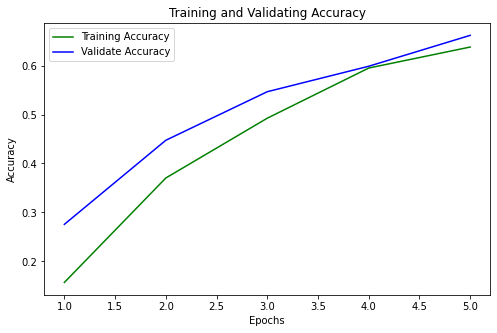

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
resNet18 = models.resnet18(pretrained=True)
for parameter in resNet18.parameters():
    parameter.requires_grad = False     # Freezing all convolutional layers
numberOfFeatures = resNet18.fc.in_features
resNet18.fc = nn.Linear(numberOfFeatures, 16)
resNet18 = resNet18.to(device)

train_dataloader = dataLoaders[3][0]
validate_dataloader = dataLoaders[3][1]
trainEvaluatePlot(5,train_dataloader,validate_dataloader,2,resNet18=resNet18)

Test Loss: 0.5514, Accuracy: 0.81


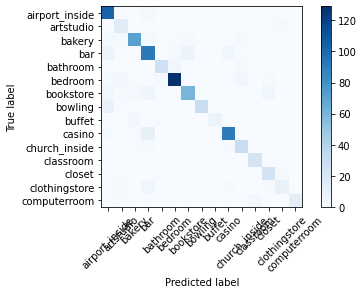

In [57]:
test_dataloader = dataLoaders[3][2]
predictions, trueLabels = Test(test_dataloader,resNet18)
predictions = predictions.argmax(dim=1)
drawConfusionMatrix(trueLabels,predictions,test_dataset.dataset.classes)

### Freezing Last Layer + FC Layer

In [59]:
resNet18 = models.resnet18(pretrained=True)
for parameter in resNet18.parameters():
    parameter.requires_grad = False     # Freezing all convolutional layers for now
numberOfFeatures = resNet18.fc.in_features
resNet18.fc = nn.Linear(numberOfFeatures, 16)
resNet18 = resNet18.to(device)

In [60]:
for name, child in resNet18.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Last layer has been unfrozen.
Model: 2 Batch Size: 300 Learning Rate: 0.001


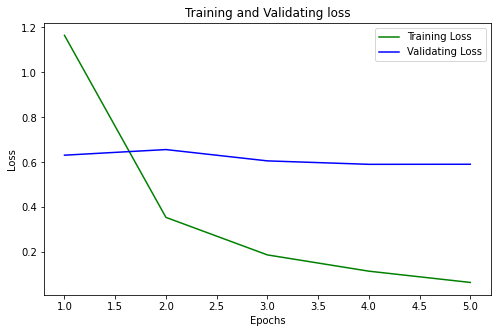

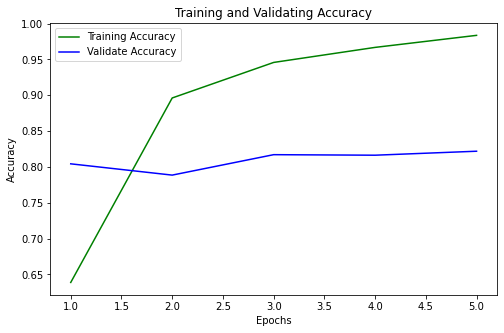

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
for name, child in resNet18.named_children():
    if name == "layer4":
        for parameter in child.parameters():
            parameter.requires_grad = True
        print("Last layer has been unfrozen.")

trainEvaluatePlot(5,train_dataloader,validate_dataloader,2,resNet18=resNet18)

Test Loss: 0.4951, Accuracy: 0.84


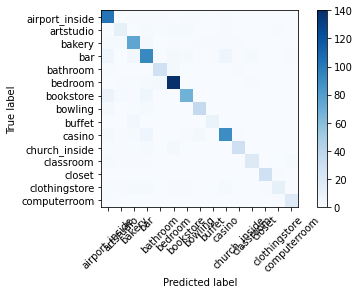

In [62]:
test_dataloader = dataLoaders[3][2]
predictions, trueLabels = Test(test_dataloader,resNet18)
predictions = predictions.argmax(dim=1)
drawConfusionMatrix(trueLabels,predictions,test_dataset.dataset.classes)

As we can easily see, accuracy is higher even just 5 epochs. Transfer learning is very powerful.

We should change hyperparameters of these last models. Because there is overfitting there.